In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [208]:
df = pd.read_csv("../data/penguins.csv")

In [209]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


## Exploratory data analysis

<AxesSubplot:xlabel='species', ylabel='count'>

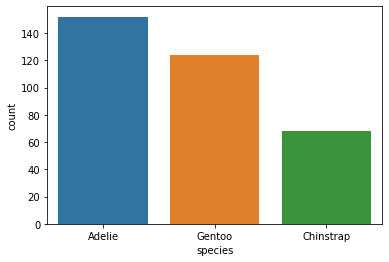

In [211]:
sns.countplot(x="species", data=df)

In [212]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [213]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


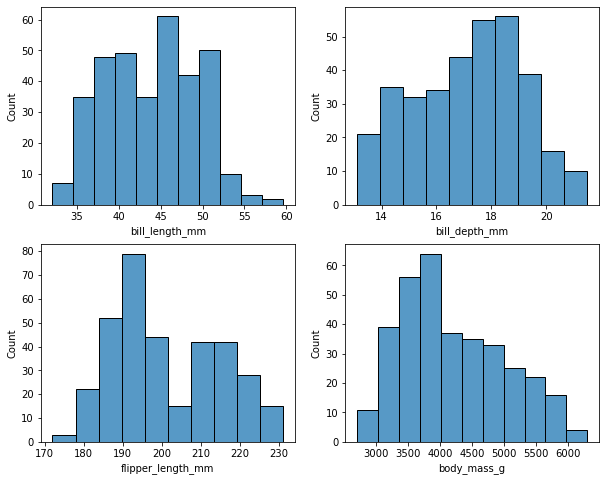

In [214]:
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col])

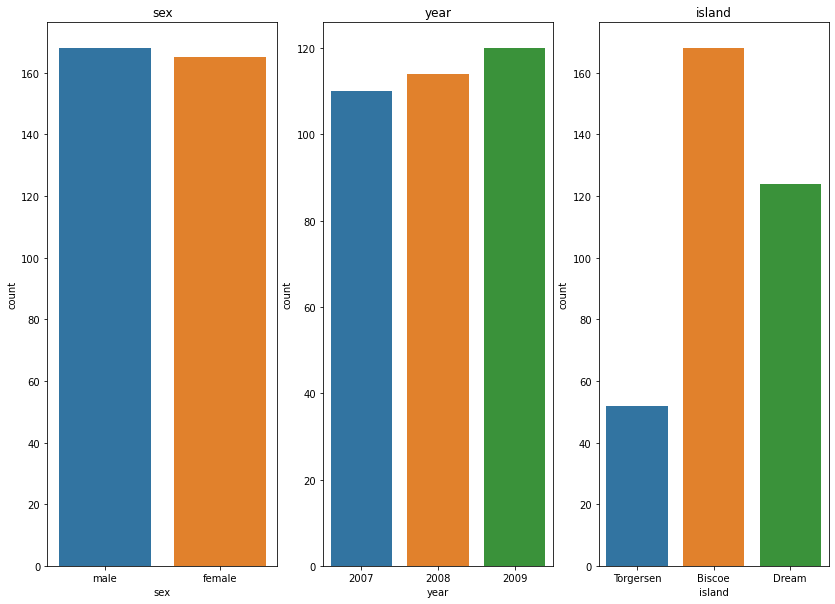

In [215]:
cat_cols = ['sex', 'year', 'island']

plt.figure(figsize=(14, 10))

for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i+1)
    plt.title(col)
    sns.countplot(x=col, data=df)

<AxesSubplot:>

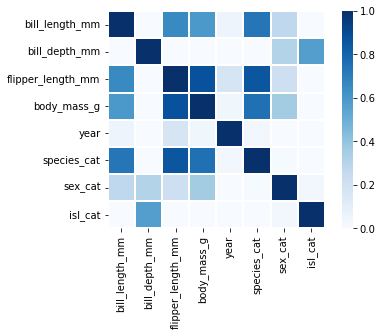

In [216]:
from sklearn.preprocessing import LabelEncoder

enc_species = LabelEncoder()
df['species_cat'] = enc_species.fit_transform(df.species)

enc_sex = LabelEncoder()
df['sex_cat'] = enc_sex.fit_transform(df.sex)

enc_isl = LabelEncoder()
df['isl_cat'] = enc_isl.fit_transform(df.island)

corr = df.corr()
sns.heatmap(corr, vmin=0, vmax=1, linewidths=2, square=True, cmap='Blues')

## Baseline model

Now we create a simple baseline model. From the EDA above, we'll use the following features:

* bill_length_mm
* bill_depth_mm
* lipper_length_mm
* body_mass_g 

In [217]:
features = ["bill_length_mm",
            "bill_depth_mm",
            "flipper_length_mm",
            "body_mass_g" ]

In [218]:
df_not_null = df.copy()
df_not_null = df_not_null.dropna()

X = df_not_null[features]
y = df_not_null.species

le = LabelEncoder()
y = le.fit_transform(y)

In [219]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

In [220]:
kn = KNeighborsClassifier()
lr = LogisticRegression(solver='liblinear')

In [221]:
kn.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [222]:
y_pred = kn.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        28
           1       0.86      0.46      0.60        13
           2       0.86      0.96      0.91        26

    accuracy                           0.82        67
   macro avg       0.83      0.76      0.77        67
weighted avg       0.82      0.82      0.81        67



In [223]:
y_pred_lr = lr.predict(X_val)

print(classification_report(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        26

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



## Hyperparameter tunning

Even though the Logistic Regression model show 100% accuracy, it seems suspicious. Insted, we'll try to fine tune the KNeighbors classifier and see why it's not so good predicting the Chinstrap class.

It might be the case that we have fewer samples for the Chinstrp class and we might need to use some techniques to deal with imbalanced classes.

In [224]:
params = {"n_neighbors": np.arange(3, 10), "metric": ["euclidean", "manhattan", "minkowski"]}

knn = KNeighborsClassifier()

grid = GridSearchCV(estimator=knn, param_grid=params)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)


0.7860936408106219
KNeighborsClassifier(metric='euclidean', n_neighbors=7)


Notes: We need to use cross validation to really understand the performance of the baseline models. Also, we need to work on the imbalanced aspect of the data.